In [1]:
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import pandas as pd
import numpy as np
import patsy
from statsmodels.graphics.correlation import plot_corr
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
dataset = pd.read_csv('pokemon.csv')

In [3]:
dataset.head()

,#,Name,Type,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [4]:
#Odstránime nepotrebné údaje
del dataset['#']
del dataset['Type2']
del dataset['Name']
del dataset['Type']
del dataset['Total']

In [5]:
dataset.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [6]:
corrMatrix = dataset.corr( method = 'pearson') #Korelačná metóda pearson využíva štandardný korelačný koeficient.
corrMatrix

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
HP,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620
Attack,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408
Defense,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377
Sp. Atk,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907
Sp. Def,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937
Speed,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715
Generation,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794
Legendary,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000


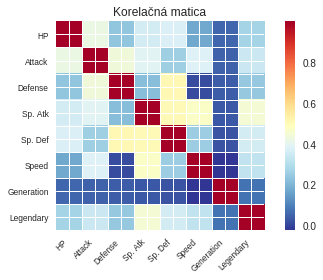

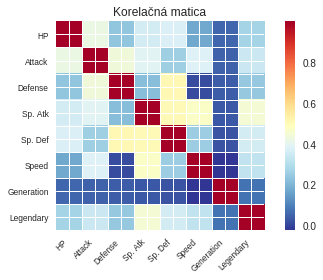

In [7]:
#Môžeme vidieť miernu koreláciu medzi legendárnymi pokémonmi a rýchlosťou útoku/obrany, a rýchlosťou.
plot_corr(corrMatrix, xnames=corrMatrix.columns, ynames=corrMatrix.columns, title='Korelačná matica', cmap='RdYlBu_r')

In [8]:
#Vidíme, že dataset nie je vybalancovaný a existuje veľké množstvo nelegendárnych pokémonov oproti legendárnym.
dataset.Legendary.value_counts()

False    735
True      65
Name: Legendary, dtype: int64

In [9]:
#Pridáme viac legendárnych pokémonov do datasetu aby sme čiastočne vybalancovali dataset
legendaryPokemons = dataset.loc[dataset['Legendary'] == True]

for x in range(0,5):
    dataset = dataset.append(legendaryPokemons)

dataset = shuffle(dataset)
dataset.Legendary.value_counts()

False    735
True     390
Name: Legendary, dtype: int64

In [10]:
#Na začiatok použijeme klasifikáciu s využitím K najbližších susedov

#Tento klasifikátor vyžaduje, aby sme štandardizovali dáta pretože veľké hodnoty by mali vpyv na výslednú predikciu
scaler = StandardScaler()
#Z dát, ktoré prechádzajú štandardizáciou vyhodíme cieľovú triedu Legendary
scaler.fit(dataset.drop('Legendary',axis=1))

#Nový dataframe použijeme pri predikcii
scaled_features = scaler.transform(dataset.drop('Legendary',axis=1))
df_feat = pd.DataFrame(scaled_features, columns=dataset.columns[:-1])
df_feat.head()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,0.898789,1.666140,0.267853,2.370664,2.445318,0.403850,-0.280417
1,-0.526775,-0.357130,-0.594335,-0.946052,-1.241489,-0.403534,0.959146
2,-0.564290,0.003178,-1.117806,-0.946052,-0.991536,2.664525,-0.280417
3,-0.301686,-0.689723,-0.501957,0.967438,1.039332,0.080896,-0.280417
4,0.898789,2.497620,2.423322,1.605268,0.258229,0.403850,-0.280417


In [11]:
#Vytvoríme si trénovacie a testovacie dáta a pomere 70:30
X_train, X_test, y_train, y_test = train_test_split(scaled_features,dataset['Legendary'],test_size=0.30)

#Pre prvý test ponecháme hodnotu K = 1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
#Vyvolanie funkcie na predikciu
predikcia = knn.predict(X_test)

In [12]:
#Porovnanie reálych a predikovaných dát
print(confusion_matrix(y_test,predikcia))

[[204   7]
 [  2 125]]


In [13]:
#Môžeme vidieť, že zvýšenie počtu legendárnych pokémonov v datasete pomohlo sieti lepšie sa natrénovať
#a tým pádom sme dostali podstatne lepšiu úspešnoť predikcie legendnárnych pokémonov
print(classification_report(y_test,predikcia))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98       211
        True       0.95      0.98      0.97       127

   micro avg       0.97      0.97      0.97       338
   macro avg       0.97      0.98      0.97       338
weighted avg       0.97      0.97      0.97       338

